# Capstone Project Progress Report

## Project objective

The objective of this project is to complement traditional retail property data with transport and social media data to offer a more robust and accurate means of predicting retail rental prices.

NYC yellow cab dropoff data is used as a proxy for potential customers while Yelp user review data is used as an indication of the business climate in the respective geographical locations of available rental units.

## Hypothesis

Taxi dropoff counts and Yelp user review metrics (Number of reviews, average review ratings, "$" rating and user review corpus sentiments) affects the prices of retail rental locations

In [1]:
import pandas as pd
import numpy as np

import random

import pickle

from sklearn.feature_extraction.text import CountVectorizer

import geopandas as gpd

import folium
from IPython.display import HTML

from shapely.geometry import Polygon, Point, MultiPolygon

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from IPython.core.display import HTML

%matplotlib inline

In [222]:
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedShuffleSplit, KFold, GridSearchCV

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.feature_selection import SelectPercentile, RFECV

In [3]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.pipeline import make_pipeline

from sklearn.metrics import mean_squared_error

## Data Wrangling

### Rental data:

- Retail rental data, webscraped from www.cityfeet.com (locations in NYC only)

In [4]:
with open ('/Users/peidacai/Desktop/rent_in_nyc_only.pkl') as f:
    rent = pickle.load(f)
    
rent.head(2)

Full_Street_address  SF_avail  Price_per_sf_per_year  \
0         327 W 57th St, New York, NY 10019      3840                 118.75   
1  118 West 14th Street, New York, NY 10011      4200                 140.00   

                                           Prop_desc   Latitude  Longitude  \
0  ("Amazing Location! Perfect for Restaurant or ...  40.767498 -73.984111   
1  ('Prime retail at the base of a luxury residen...  40.737628 -73.997937   

       City  Zipcode                   Position             block_id  
0  New York    10019  [-73.9841113, 40.7674983]  15000US360610139007  
1  New York    10011  [-73.9979368, 40.7376285]  15000US360610071001

In [5]:
rent.shape

(554, 10)

### Taxi data:

- 12 months of taxi data was downloaded from NYC Taxi and Limousine Commission (TLC). However, due to the size of the file, only 1% of this set was used

In [6]:
with open('/Users/peidacai/Desktop/taxi_dropoff_block_df.pkl') as f:
    taxi = pickle.load(f)

taxi.head(2)

tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  trip_distance  \
0  2015-07-01 00:00:20   2015-07-01 00:07:57                1           2.10   
1  2015-07-01 00:00:42   2015-07-01 00:08:27                2           1.18   

   pickup_longitude  pickup_latitude  RatecodeID  dropoff_longitude  \
0        -73.983780        40.755219           1         -73.987389   
1        -74.003471        40.725307           1         -74.004333   

   dropoff_latitude  payment_type         ...           trip_month  \
0         40.733372             1         ...                    7   
1         40.737984             1         ...                    7   

   day_of_week  pickup_hour  dropoff_hour  trip_duration    Avg_spd  \
0            2            0             0            7.0  18.000000   
1            2            0             0            7.0  10.114286   

                     dropoff_point  zipcode                    dropoff_Point  \
0  [-73.9873886108, 40.7333717346]    10003  [-73.9873886108, 40.7333717346]   
1  [-74.0043334961, 40.7379837036]    10014  [-74.0043334961, 40.7379837036]   

         dropoff_block  
0  15000US360610042001  
1  15000US360610077003  

[2 rows x 27 columns]

In [7]:
taxi.shape

(1316850, 27)

### Social media (Yelp business reviews) data:

- For each rental location in the first dataframe, data was scraped from Yelp.com for the respective top 10 nearest businesses.
- For each of these neighboring businesses, the first 20 user reviews were obtained for sentiment analyses of the geographical location.

In [291]:
with open('/Users/peidacai/Desktop/yelp_data_cleaned.pkl') as f:
    yelp = pickle.load(f)

yelp.head(2)

Business_name                   Street_address  Cost  Rating  \
0  Sfilatino Italian Gourmet  342 W 57th StNew York, NY 10019     2     4.0   
1     ABA Turkish Restaurant  325 W 57th StNew York, NY 10019     2     4.0   

   Review Count                                        Web_address  \
0           121  https://www.yelp.com/biz/sfilatino-italian-gou...   
1           275  https://www.yelp.com/biz/aba-turkish-restauran...   

                      Rental_address  cate_american  cate_asian  \
0  327 W 57th St, New York, NY 10019              0           0   
1  327 W 57th St, New York, NY 10019              0           0   

   cate_bakeries    ...      cate_spanish  cate_sushi  cate_tapas  cate_tea  \
0              0    ...                 0           0           0         0   
1              0    ...                 0           0           0         0   

   cate_thai  cate_traditional  cate_vegan  cate_vegetarian  cate_venues  \
0          0                 0           0                0            0   
1          0                 0           0                0            0   

   cate_wine  
0          0  
1          0  

[2 rows x 57 columns]

In [292]:
yelp.shape

(5510, 57)

### Neighboring businesses user reviews

In [10]:
with open('/Users/peidacai/Desktop/yelp_reviews2.pkl') as f:
    reviews = pickle.load(f)

reviews.head(2)

Reviewer_location                                        Review_text  \
0     Manhattan, NY  Absolutely love this place!! I always order a ...   
1  White Plains, NY  Good Pizza. Delivery on time. Will try again. ...   

                                         biz_webpage  
0  https://www.yelp.com/biz/giovanis-big-pizza-br...  
1  https://www.yelp.com/biz/giovanis-big-pizza-br...

In [11]:
reviews.shape

(30005, 3)

### Combined data: Rent, taxi, yelp

In [4]:
with open('/Users/peidacai/Desktop/rent_yelp_taxi_df.pkl') as f:
    rent_yelp_taxi = pickle.load(f)

rent_yelp_taxi.head(2)

Full_Street_address  SF_avail  Price_per_sf_per_year  \
0         327 W 57th St, New York, NY 10019      3840                 118.75   
1  118 West 14th Street, New York, NY 10011      4200                 140.00   

                                           Prop_desc   Latitude  Longitude  \
0  ("Amazing Location! Perfect for Restaurant or ...  40.767498 -73.984111   
1  ('Prime retail at the base of a luxury residen...  40.737628 -73.997937   

       City  Zipcode                   Position             block_id  \
0  New York    10019  [-73.9841113, 40.7674983]  15000US360610139007   
1  New York    10011  [-73.9979368, 40.7376285]  15000US360610071001   

           ...           Review_min  Sentiment_mean  Sentiment_std  \
0          ...                   41        0.211583       0.060270   
1          ...                   32        0.200312       0.063121   

   Sentiment_max  Sentiment_min  dropoff_count  dropoff_hr_0600_1200  \
0       0.317372       0.100961           1681                 369.0   
1       0.292630       0.123966            794                 157.0   

   dropoff_hr_1200_1800  dropoff_hr_1800_2359  dropoff_hr_2359_0600  
0                 549.0                 564.0                 199.0  
1                 269.0                 258.0                 110.0  

[2 rows x 31 columns]

In [11]:
rent_yelp_taxi.columns

Index([u'Full_Street_address', u'SF_avail', u'Price_per_sf_per_year',
       u'Prop_desc', u'Latitude', u'Longitude', u'City', u'Zipcode',
       u'Position', u'block_id', u'Cost_mean', u'Cost_std', u'Cost_max',
       u'Cost_min', u'Rate_mean', u'Rate_std', u'Rate_max', u'Rate_min',
       u'Review_mean', u'Review_std', u'Review_max', u'Review_min',
       u'Sentiment_mean', u'Sentiment_std', u'Sentiment_max', u'Sentiment_min',
       u'dropoff_count', u'dropoff_hr_0600_1200', u'dropoff_hr_1200_1800',
       u'dropoff_hr_1800_2359', u'dropoff_hr_2359_0600'],
      dtype='object')

In [12]:
rent_yelp_taxi.shape

(542, 31)

## EDA

### Rental EDA

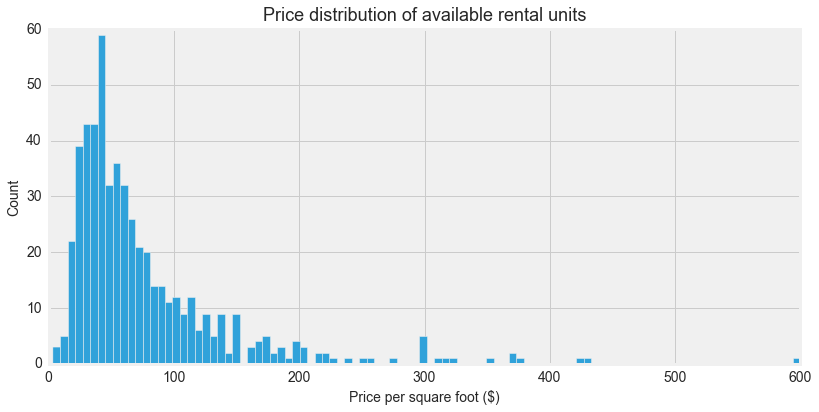

In [15]:
# Price distribution of available rental units

ax = rent_yelp_taxi[rent_yelp_taxi['SF_avail'] < 20000]['Price_per_sf_per_year'].hist(figsize = (12, 6), bins = 100)
ax.tick_params(axis='both', labelsize = 14)
ax.set_title('Price distribution of available rental units', y = 1.01, fontsize = 18)
ax.set_ylabel('Count', fontsize = 14)
ax.set_xlabel('Price per square foot ($)', fontsize = 14)
plt.savefig('Price_distribution_rent_units.png');

In [16]:
rent_yelp_taxi['Price_per_sf_per_year'].describe()

count    542.000000
mean      76.420535
std       67.559812
min        3.340000
25%       36.000000
50%       55.500000
75%       90.000000
max      600.000000
Name: Price_per_sf_per_year, dtype: float64

In [17]:
rent_yelp_taxi[rent_yelp_taxi['Price_per_sf_per_year'] > 500]

Full_Street_address  SF_avail  Price_per_sf_per_year  \
276  147 Spring Street, New York, NY 10012      1800                  600.0   

                                             Prop_desc   Latitude  Longitude  \
276  ('Located between Wooster and West Broadway.  ...  40.724437 -74.001269   

         City  Zipcode                   Position             block_id  \
276  New York    10012  [-74.0012695, 40.7244374]  15000US360610049001   

             ...           Review_min  Sentiment_mean  Sentiment_std  \
276          ...                   22        0.257579       0.056347   

     Sentiment_max  Sentiment_min  dropoff_count  dropoff_hr_0600_1200  \
276       0.373362       0.185547           4878                1312.0   

     dropoff_hr_1200_1800  dropoff_hr_1800_2359  dropoff_hr_2359_0600  
276                2222.0                1143.0                 201.0  

[1 rows x 31 columns]

#### Comments:

Average rental prices in NYC should be in the region of about \$800 per square foot per year, with the highest prices in the region of about \$4,000. The price distribution is very much lower than the values reported in the [media](https://www.rebny.com/content/rebny/en/newsroom/research/REBNYRetailReport/Spring_2016_Manhattan_Retail_Report.html). Average prices on 34th street between 5th and 7th avenue is about \$890.

Prime units such as these are usually not listed publicly on the market, they are usually marketed exclusively by high end property management companies.

Nevertheless, while not ideal, the project can continue with the current set of rental units.

In [18]:
rent_yelp_taxi[rent_yelp_taxi['SF_avail'] < 20000]['SF_avail'].describe()

count      542.000000
mean      2739.662362
std       2825.287836
min        225.000000
25%       1000.000000
50%       1747.000000
75%       3200.000000
max      17785.000000
Name: SF_avail, dtype: float64

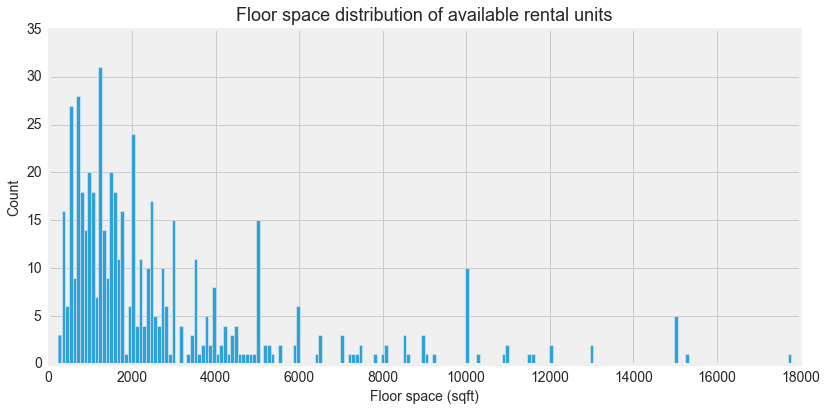

In [19]:
# Floor space distribution of available rental units (< 20,000)

ax = rent_yelp_taxi[rent_yelp_taxi['SF_avail'] < 20000]['SF_avail'].hist(figsize = (12, 6), bins = 200)
ax.tick_params(axis='both', labelsize = 14)
ax.set_title('Floor space distribution of available rental units', y = 1.01, fontsize = 18)
ax.set_ylabel('Count', fontsize = 14)
ax.set_xlabel('Floor space (sqft)', fontsize = 14)
plt.savefig('Floor_space_distribution_rent_units.png');

#### Comments:

There were 10 listings which were over 20,000 sqft in the dataset in terms of available floor space. Most of these were listings for entire projects, with floor space and psf data entered as the largest and lowest respectively. The decision was to drop these entries as such potential market for extraordinarily large spaces is very small and summarized information for entire projects is unreliable.

Sidenote: From the histogram above, it also seem to indicate that listings tend to round floor spaces to whole numbers, as indicated by the spikes in round number floor spaces such as 5,000, 10,000 and 15,000.

In [20]:
price_size = rent_yelp_taxi[rent_yelp_taxi['SF_avail'] < 20000][['Price_per_sf_per_year', 'SF_avail']]

scale = RobustScaler()

price_size = scale.fit_transform(price_size)
price_size = pd.DataFrame(price_size, columns = ['Price_per_sf_per_year', 'SF_avail'])

In [21]:
price_size.describe()

Price_per_sf_per_year    SF_avail
count             542.000000  542.000000
mean                0.387417    0.451210
std                 1.251108    1.284222
min                -0.965926   -0.691818
25%                -0.361111   -0.339545
50%                 0.000000    0.000000
75%                 0.638889    0.660455
max                10.083333    7.290000

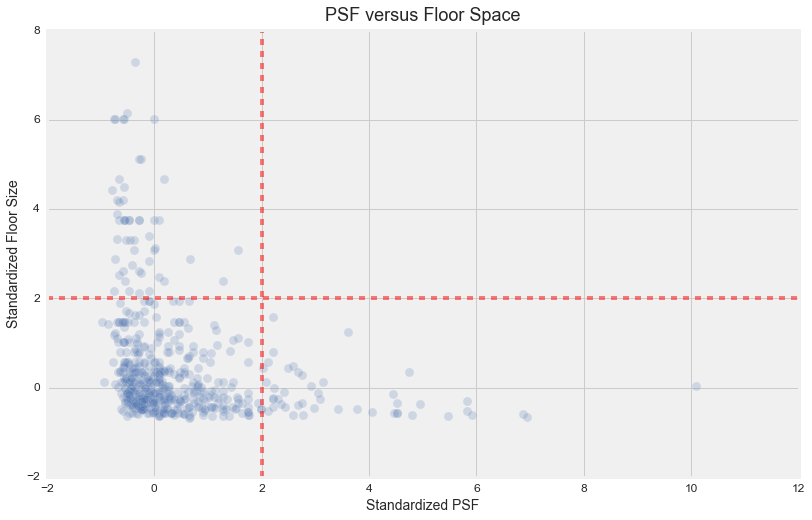

In [22]:
ax = price_size.plot.scatter('Price_per_sf_per_year', 'SF_avail', figsize = (12,8), s = 80, alpha  = 0.2)

ax.axvline(x = 2,  linestyle='--', color = 'r', alpha = 0.5)
ax.axhline(y = 2,  linestyle='--', color = 'r', alpha = 0.5)

ax.tick_params(axis = 'both', labelsize = 12)
ax.set_ylabel('Standardized Floor Size', fontsize = 14)
ax.set_xlabel('Standardized PSF', fontsize = 14)
ax.set_title('PSF versus Floor Space', y = 1.01, fontsize = 18)
plt.savefig('Scatter_psf_floor_space.png');

In [23]:
# Correlation of PSF witih floor space
price_size.corr()

Price_per_sf_per_year  SF_avail
Price_per_sf_per_year               1.000000 -0.264614
SF_avail                           -0.264614  1.000000

#### Comments:

All large units (> 2 standardized unit) has low prices (< 2) and all expensive units (> 2) have small sizes (< 2).

### Taxi EDA - Dropoff counts by the hour

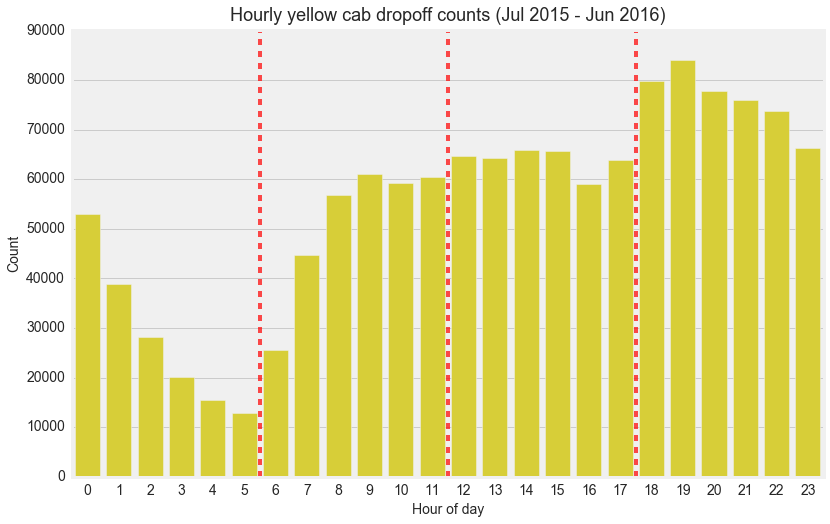

In [24]:
# Dropoff distribution across hour of day

plt.figure(figsize=(12,8))
ax = sns.countplot(x = 'dropoff_hour', data = taxi, color='#F2E51D')

# Potential bins for modelling later
ax.axvline(x = 5.5,  linestyle='--', color = 'r', alpha = 0.7)
ax.axvline(x = 11.5,  linestyle='--', color = 'r', alpha = 0.7)
ax.axvline(x = 17.5,  linestyle='--', color = 'r', alpha = 0.7)

ax.set_xlabel('Hour of day', fontsize = 14)
ax.set_ylabel('Count', fontsize = 14)
ax.tick_params(axis = 'both', labelsize = 14)
ax.set_title('Hourly yellow cab dropoff counts (Jul 2015 - Jun 2016)', y = 1.01, fontsize = 18)

plt.savefig('hourly_taxi_dropoff_count.png');

#### Comments:

Passenger dropoff counts plotted against the dropoff hour of the day showed that the time of the day can be broken down into 4 groups:

- Nightlife group
- Morning rush-hour group
- Tourists/Meeting group
- Evening rush-hour group

Binning into such groups could be useful to isolate rental locations for specific business needs such as restaurants, fashion or gyms.

### Taxi EDA - Dropoff count by city blocks

In [25]:
# Loading in a dataframe of dropoff counts by city blocks
# Created separately

with open('/Users/peidacai/Desktop/taxi_dropoff_count_df.pkl', 'r') as f:
    df2 = pickle.load(f)

In [26]:
df2.sort_values('count', ascending = False).head(2)

dropoff_block  count
3460  15000US360610101001  29987
3457  15000US360610099001  19620

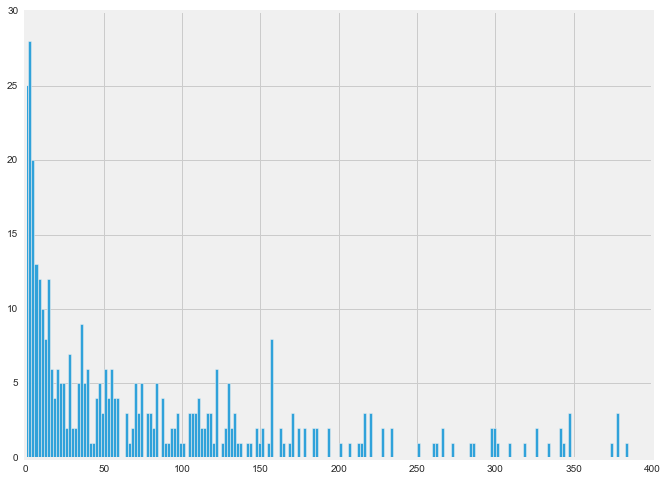

In [27]:
rent_yelp_taxi[rent_yelp_taxi['dropoff_count'] < 400]['dropoff_count'].hist(bins = 200, figsize = (10,8))

In [28]:
rent_yelp_taxi['dropoff_count'].describe()

count      542.000000
mean       675.680812
std       1758.797993
min          0.000000
25%         18.250000
50%         95.500000
75%        472.000000
max      19620.000000
Name: dropoff_count, dtype: float64

In [29]:
# Using folium to create the html file

# Defining path for geojson cityblock overlay for NYC city block boundaries
nyc_block_geo = '/Users/peidacai/Desktop/rdf.json'

# Initializing starting center position and zoom_state
m = folium.Map(location=[40.748660, -73.985741], zoom_start=13)


# Add a geojson layer of the zipcode from geojson file containing NYC zipcode polygons
m.choropleth(geo_path = nyc_block_geo,
             
             #Adding choropleth layer
             data = df2,
             columns = ['dropoff_block', 'count'],
             
             key_on = 'feature.properties.geo_id',
             threshold_scale=[0,500,3000,8000,15000,30000],
             fill_color = 'YlGnBu',
             fill_opacity = 0.6,
             line_opacity = 0.1,
             legend_name = 'Taxi dropoff counts',
             reset = True
              )

# Displaying inline
m


#### Comments:

I wanted to use NYC city block data, however, due to its high granularity nature, it is computationally inefficient. Therefore, this geojson file was chosen instead, as a compromise between cityblock and zipcodes.

Beside the transport hubs such as Penn and Grand Central Stations and the airports, the other highest dropoff places were on the west, near Jacob Javits Convention Center as well as Central Park.

There are smaller pockets of high dropoff blocks in downtown, around 23rd street and Union Square.

## How much is taxi passengers worth to retail business owners?

In [473]:
# Removing outliers

r = rent_yelp_taxi[rent_yelp_taxi['dropoff_count']<= 10000]
r = r[r['Price_per_sf_per_year'] <= 400]

In [474]:
lr = LinearRegression()
lr.fit(r['dropoff_count'].values.reshape(1,-1), r['Price_per_sf_per_year'].values.reshape(1,-1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [475]:
line_coef = np.polyfit(r['dropoff_count'].values,
                       r['Price_per_sf_per_year'].values,
                       1)
line_coef

array([  2.03150034e-02,   6.24798615e+01])

In [483]:
# Coefficient indicated every 100 increase in passenger dropoff, retailers pay $0.02 psf per year more
# 100 since we used only 1% of the entire taxi data
# so 1 unit increase on x-axis is 100 increase in passenger dropoff

# Equation is:
# Coefficient * 1000 passenger dropoff * Average size of retail location
# Returns additional rental to pay for every 100,000 increase in passenger dropoff every year

line_coef[0] *1000 * 2700

54850.509242866363

### Comments:

On average, retail business owners are expected to pay a premium of about \$20.3 per sqft per year more for every 100,000 more passenger dropoff. For a mean floor area of 2,700, this amounts to about \$54,850 increased every year, or about \$0.55 per passenger per year. Can higher taxi dropoff be translated to higher revenue? We will need to marry this analyses with sales data to justify this:

- Conversion rate of taxi dropoff to sales (Revenue per dropoff)
    - Examine relationship between taxi dropoff counts and sales based on existing locations
- COGS
    - Justify that increase in sales from higher passenger dropoff areas is economically viable

In [477]:
polynomial = np.poly1d(line_coef)

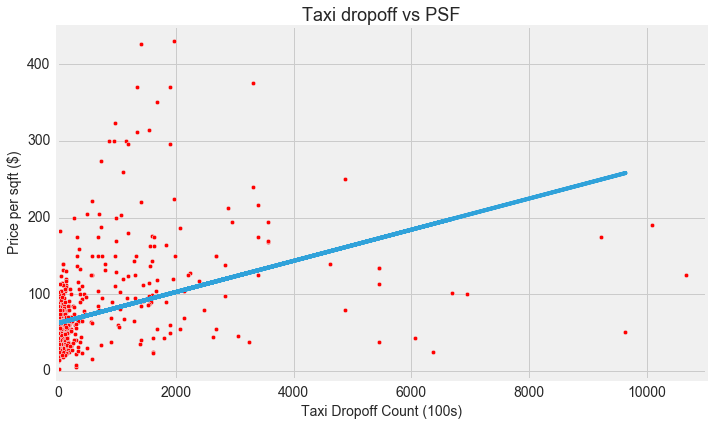

In [480]:
plt.figure(figsize = (10,6))

ax = plt.plot(r['dropoff_count'].values, polynomial(r['dropoff_count'].values))
plt.scatter(rent_yelp_taxi['dropoff_count'], rent_yelp_taxi['Price_per_sf_per_year'], s = 20, c = 'r')
plt.ylabel('Price per sqft ($)', fontsize = 14)
plt.xlabel('Taxi Dropoff Count (100s)', fontsize = 14)
plt.ylim(-10,450)
plt.xlim(-10,11000)
plt.title('Taxi dropoff vs PSF', fontsize = 18)
plt.tick_params(axis = 'both', labelsize = 14)
plt.tight_layout()

plt.savefig('Scatter_psf_dropoff.png');


# Yelp Data EDA: Metrics for top 10 nearest businesses

![top_10_businesses](top_10_nearest_businesses_yelp.png)

For each available rental location, social media data is obtained from webscraping Yelp for top 10 nearest businesses for the following metrics:

    1. "$" metric: 
    
        An indication of the type of market in the vincity, i.e. spending power of target segment of businesses in the area

    2. Review ratings: 
    
        While this depends solely on the performance of each individual business, it provides an indication of the acceptability of businesses in the geographical location. It could be a business decision to locate themselves within high performing neighbors or otherwise. A classic big fish in small pond versus small fish in big pond consideration. Another consideration could be locating near complementary businesses, for example a dessert place near high performing restaurant areas to capture after-meal crowds.

    3. Average number of reviews:
    
        This is an indication of the popularity of the geographical location, which is an indication of the potential reach of a geographical location.

## Yelp descriptive statistics

In [488]:
# Descriptive statistics for Yelp "$" metrics
# Descriptive statistics for Yelp user rating (based on 5 stars) metrics
# Descriptive statistics for Yelp number of reviews metrics
# Descriptive statistics for Yelp user review text sentiment analyses metrics

rent_yelp_taxi[['Cost_mean', 'Rate_mean', 'Review_mean', 'Sentiment_mean']].describe()

Cost_mean   Rate_mean  Review_mean  Sentiment_mean
count  542.000000  542.000000   542.000000      542.000000
mean     1.763284    4.131642   192.319188        0.230522
std      0.305069    0.196720   167.480481        0.028009
min      1.000000    3.450000     7.500000        0.076548
25%      1.600000    4.050000    75.775000        0.215683
50%      1.700000    4.150000   136.000000        0.230790
75%      1.900000    4.250000   258.425000        0.248086
max      3.100000    4.600000  1144.600000        0.333194

In [32]:
# Creating a label of 1 for units with psf above mean and 0 otherwise

rent_yelp_taxi['PSF_Above_mean'] = rent_yelp_taxi['Price_per_sf_per_year'].apply(lambda x: 1 if x > rent_yelp_taxi['Price_per_sf_per_year'].mean() else 0)

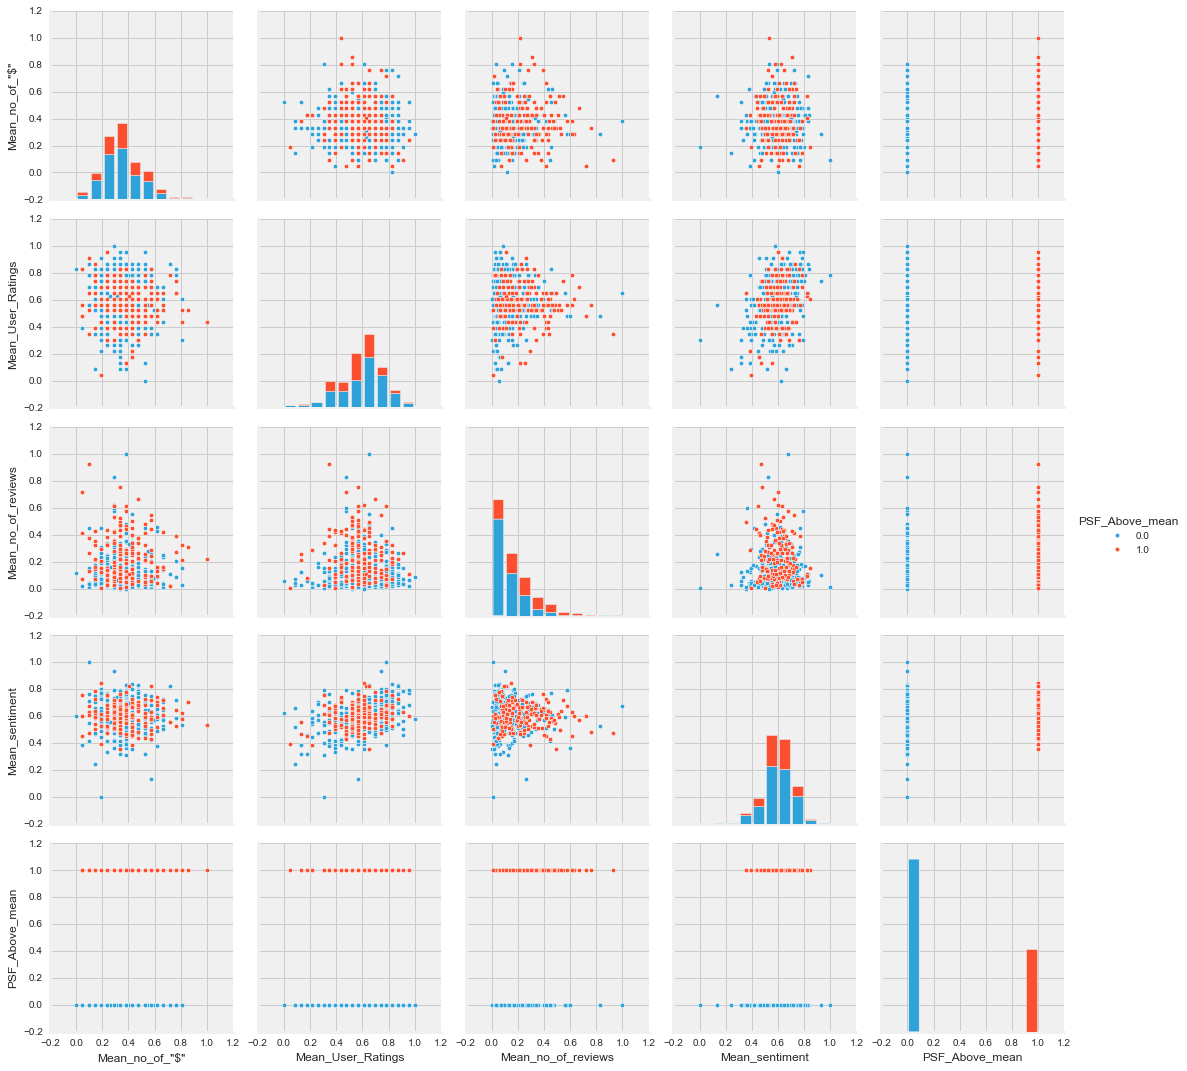

In [33]:
yelp = rent_yelp_taxi[['Cost_mean', 
                       'Rate_mean', 
                       'Review_mean',
                       'Sentiment_mean',
                       'PSF_Above_mean']]

yelp_scale = pd.DataFrame(MinMaxScaler().fit_transform(yelp), columns= ['Mean_no_of_"$"', 
                                                           'Mean_User_Ratings',
                                                           'Mean_no_of_reviews',
                                                           'Mean_sentiment',
                                                           'PSF_Above_mean'])
sns.pairplot(yelp_scale, size = 3, aspect = 1, hue = 'PSF_Above_mean')

#### Comments:

The cost metric (number of '$') and user rating didn't seem to have meaningful predictive abilities. However, it seemed that number of reviews had some meaningful differences.

In [34]:
rent_yelp_taxi.head(1)

Full_Street_address  SF_avail  Price_per_sf_per_year  \
0  327 W 57th St, New York, NY 10019      3840                 118.75   

                                           Prop_desc   Latitude  Longitude  \
0  ("Amazing Location! Perfect for Restaurant or ...  40.767498 -73.984111   

       City  Zipcode                   Position             block_id  \
0  New York    10019  [-73.9841113, 40.7674983]  15000US360610139007   

        ...        Sentiment_mean  Sentiment_std  Sentiment_max  \
0       ...              0.211583        0.06027       0.317372   

   Sentiment_min  dropoff_count  dropoff_hr_0600_1200  dropoff_hr_1200_1800  \
0       0.100961           1681                 369.0                 549.0   

   dropoff_hr_1800_2359  dropoff_hr_2359_0600  PSF_Above_mean  
0                 564.0                 199.0               1  

[1 rows x 32 columns]

In [35]:
# Pivoting yelp data to demonstrate differences in mean between yelp metrics

yelp_piv = pd.pivot_table(yelp_scale, ['Mean_no_of_"$"',
                                       'Mean_User_Ratings',
                                       'Mean_no_of_reviews',
                                       'Mean_sentiment'], 
                          index = 'PSF_Above_mean')

yelp_piv.reset_index(inplace = True, drop = True)
yelp_piv.T

0         1
Mean_User_Ratings   0.604016  0.569068
Mean_no_of_"$"      0.355845  0.379456
Mean_no_of_reviews  0.126388  0.238343
Mean_sentiment      0.599140  0.601644

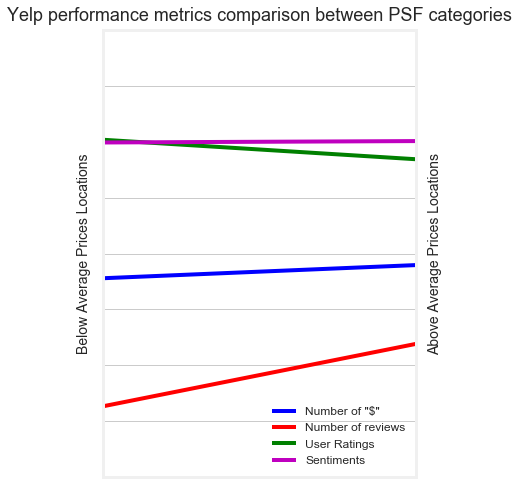

In [36]:
# Plotting yelp performance metrics comparison between PSf categories

x = [0,1]

a = yelp_piv.loc[:, 'Mean_no_of_"$"'].T.values

b = yelp_piv.loc[:, 'Mean_no_of_reviews'].T.values

c = yelp_piv.loc[:, 'Mean_User_Ratings'].T.values

d = yelp_piv.loc[:, 'Mean_sentiment'].T.values

fig, ax = plt.subplots(figsize = (5,8))
ax2 = ax.twinx()
ax.set_axis_bgcolor('white')
ax.grid(which='major',axis = 'x')
ax2.grid(which='major',axis = 'x')

line_a = plt.plot(x, a, 'xb-', label = 'Number of "$"')
line_b = plt.plot(x, b, 'xr-', label = 'Number of reviews')
line_c = plt.plot(x, c, 'xg-', label = 'User Ratings')
line_d = plt.plot(x, d, 'xm-', label = 'Sentiments')

plt.legend(loc='lower right', fontsize = 12)

ax.set_xticklabels([])
ax2.set_yticklabels([])
ax.set_yticklabels([])

ax.set_ylim(0,0.8)
ax2.set_ylim(0,0.8)

ax.set_ylabel('Below Average Prices Locations', fontsize = 14)
ax2.set_ylabel('Above Average Prices Locations', fontsize = 14)


ax.set_title('Yelp performance metrics comparison between PSF categories', y = 1.01, fontsize = 18)
plt.savefig('yelp_performance_compare.png');

#### Comments:

This chart compare yelp metrics between rental units with PSF below or equal to mean (left axis) and units above mean PSF (right axis). Each line represents a yelp performance metric. If there were significant differences between the two PSF categories, we should be seeing lines with high gradients.

The metric which showed highest discriminating ability between the categories was "Number of reviews" (or popularity of a location). Rental locations with prices above the mean PSF had higher number of yelp reviews.

Interestingly, mean user ratings for businesses in "expensive" areas were lower than businesses in "cheaper" areas, evident from the downward sloping green line, though not by much.

Expensive locations didn't correlate with "Number of '$'". Businesses targeting higher-spending power consumers did not neccesarily locate themselves in expensive rental locations.

Finally, sentiment analyses didn't offer much in discriminating ability, may consider to drop this feature when modelling to improve performance.

## How much does 1 more Yelp user review cost retailers?

Since number of Yelp user reviews for businesses in the vicinity seemed to be more correlated, a linear regression is conducted on number of reviews to price to identify the per unit cost of an additional user review.

In [489]:
lr = LinearRegression()
lr.fit(rent_yelp_taxi['Review_mean'].values.reshape(1,-1), rent_yelp_taxi['Price_per_sf_per_year'].values.reshape(1,-1))

line_coef = np.polyfit(rent_yelp_taxi['Review_mean'].values,
                       rent_yelp_taxi['Price_per_sf_per_year'].values,
                       1)
polynomial = np.poly1d(line_coef)

line_coef

array([  0.1525766 ,  47.07712759])

In [491]:
# Cost of 1 more Yelp review for nearby businesses in rental per year
line_coef[0] * 2700

411.9568146737588

In [493]:
# Percentage increase in rental price for every increase in number of Yelp reviews for top 10 nearby businesses
# For average PSF of $76 per year
line_coef[0]/76 *100

0.20075868161489219

### Comments:

On average, every single increase in average number of reviews for top 10 nearest businesses on Yelp results in \$0.15 increase in PSF per year. For an average sized rental location of 2,700 sqft, \$76 PSF per year, 1 increase in Yelp review increases rent by \$411.96 per year; or 0.2 %.

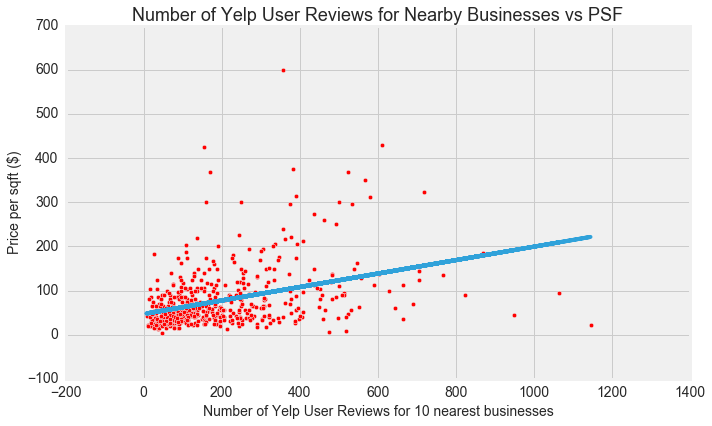

In [494]:
plt.figure(figsize = (10,6))

ax = plt.plot(rent_yelp_taxi['Review_mean'].values, polynomial(rent_yelp_taxi['Review_mean'].values))
plt.scatter(rent_yelp_taxi['Review_mean'], rent_yelp_taxi['Price_per_sf_per_year'], s = 20, c = 'r')
plt.ylabel('Price per sqft ($)', fontsize = 14)
plt.xlabel('Number of Yelp User Reviews for 10 nearest businesses', fontsize = 14)
#plt.ylim(-10,450)
#plt.xlim(-10,11000)
plt.title('Number of Yelp User Reviews for Nearby Businesses vs PSF', fontsize = 18)
plt.tick_params(axis = 'both', labelsize = 14)
plt.tight_layout()

plt.savefig('Scatter_psf_yelp_review.png');


# Combined analyses

In [37]:
rev_taxi_psf = rent_yelp_taxi[['Review_mean', 'dropoff_count', 'PSF_Above_mean']]

rev_taxi_psf = pd.DataFrame(RobustScaler().fit_transform(rev_taxi_psf), columns = ['Review_mean', 'dropoff_count', 'PSF_Above_mean'])

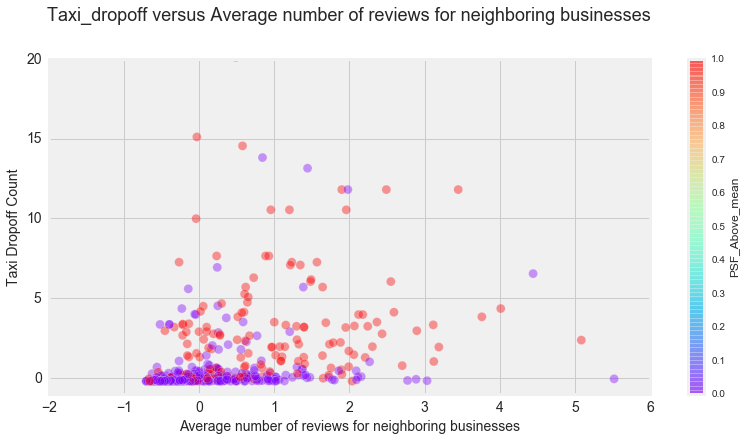

In [38]:
ax = rev_taxi_psf.plot.scatter('Review_mean', 'dropoff_count', c = 'PSF_Above_mean', 
                          cmap = 'rainbow', s = 80, figsize = (12,6), alpha = 0.4,
                          sharex = False)
ax.set_ylim(-1, 20)

ax.set_xlabel('Average number of reviews for neighboring businesses', fontsize = 14)
ax.set_ylabel('Taxi Dropoff Count', fontsize = 14)
ax.tick_params(axis = 'both', labelsize = 14)

ax.set_title('Taxi_dropoff versus Average number of reviews for neighboring businesses', y = 1.1, fontsize = 18)
plt.savefig('taxi_review_count_psf.png');

In [16]:
rent_yelp_taxi.head(1)

Full_Street_address  SF_avail  Price_per_sf_per_year  \
0  327 W 57th St, New York, NY 10019      3840                 118.75   

                                           Prop_desc   Latitude  Longitude  \
0  ("Amazing Location! Perfect for Restaurant or ...  40.767498 -73.984111   

       City  Zipcode                   Position             block_id  \
0  New York    10019  [-73.9841113, 40.7674983]  15000US360610139007   

           ...           Review_min  Sentiment_mean  Sentiment_std  \
0          ...                   41        0.211583        0.06027   

   Sentiment_max  Sentiment_min  dropoff_count  dropoff_hr_0600_1200  \
0       0.317372       0.100961           1681                 369.0   

   dropoff_hr_1200_1800  dropoff_hr_1800_2359  dropoff_hr_2359_0600  
0                 549.0                 564.0                 199.0  

[1 rows x 31 columns]

In [17]:
comb_rent = rent_yelp_taxi[['Price_per_sf_per_year',
                            'SF_avail',
                            'dropoff_count', 
                            'dropoff_hr_0600_1200', 'dropoff_hr_1200_1800', 
                            'dropoff_hr_1800_2359', 'dropoff_hr_2359_0600',
                            'Cost_mean', 'Rate_mean',
                            'Review_mean', 'Sentiment_mean']]

In [31]:
ss = StandardScaler()
mm = MinMaxScaler()
rb = RobustScaler()

In [6]:
# Function to return name of ML model and/or scaling method

def return_name(algo):
    return str(algo).split('(')[0]

StandardScaler

++++++++++++++++++++



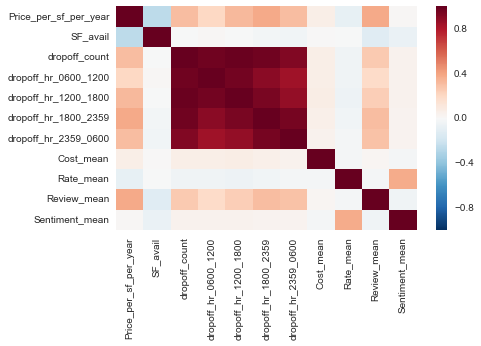

MinMaxScaler

++++++++++++++++++++



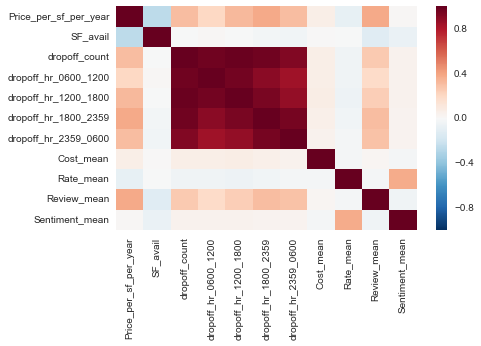

RobustScaler

++++++++++++++++++++



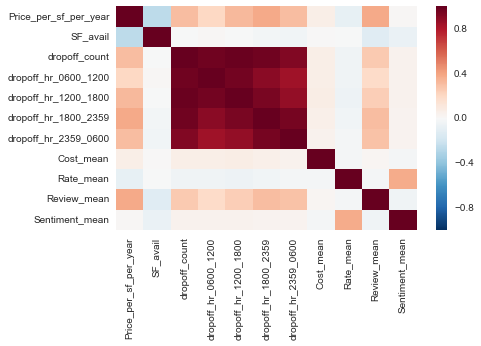

In [33]:
scales = [ss, mm, rb]

for scale in scales:
    scaled_comb_rent = pd.DataFrame(scale.fit_transform(comb_rent), columns = comb_rent.columns)
    print return_name(scale)
    print
    sns.heatmap(scaled_comb_rent.corr())
    print "++++++++++++++++++++"
    print
    plt.show()

#### Comments:

In line with the earlier analyses, higher taxi dropoffs and higher number of yelp reviews in the area did seem to point towards more above average PSF locations.

# Modelling

## Approach

To test the hypothesis, the following approach to modeling will be adopted:

1. Fix random state
2. Specify a fix number of different modeling algorithms with a fixed number of scaling algorithms
3. Compare cross_val_scores of all models (default settings) for the following sets of features:

    a. Floor space available, zipcodes
    b. Floor space available, zipcodes, taxi dropoff count
    c. Floor space available, zipcodes, taxi dropoff count and Yelp review data
4. Both classifier and regressors will be created for all combinations of models and scalers

## Performance metrics

Since the aim of the project is to predict prices in their continuous form, regressor modeling is chosen over classifier. To compare performance between modeling algorithms, two performance metrics come to mind:

    1. Mean squared error (MSE)
    
    MSE is the estimate of the variance of residuals provides an intuitive approach to performance comparison. Root Mean Squared Error (RMSE) can be easily obtained from this metric and performance would be measured in the average error in dollar amount, same units as the predictor (Price per sqft). However, the downside of this metric is its inability to indicate performance across the entire range of inputs. Maximizing RMSE could be done at the expense of higher variance, when may result in the inability of the chosen model to generalize well.
    
    2. Coefficient of determination (R2 scores)
    
    Another more appropriate measure of performance for regressors would be R2 scores. It provides a measure of how close the data is from the regression line

# Setting up modeling parameters

In [22]:
# Defining a fixed random state
rand = 44

In [23]:
# Regressors models

rfr = RandomForestRegressor(random_state=rand)
etr = ExtraTreesRegressor(random_state=rand)
adar = AdaBoostRegressor(random_state=rand)
gbr = GradientBoostingRegressor(random_state=rand)
linr = LinearRegression()
knnr = KNeighborsRegressor()
svr = SVR()

In [24]:
# List of different regressors models
model_reg = [rfr, etr, adar, gbr, linr, knnr, svr]

In [25]:
stand_scale = StandardScaler()
rob_scale = RobustScaler()
minmax_scale = MinMaxScaler()

In [26]:
# List of different scaling methods
scales = [stand_scale, rob_scale, minmax_scale]

In [18]:
# Function to return name of ML model and/or scaling method

def return_name(algo):
    return str(algo).split('(')[0]

In [389]:
def custom_cross_val(X, y, folds, mod_list, scal_list, no_cont_cols):
    
    #=========Inputs=========================
    # X: the feature matrix in dataframe form
    # continuous features on left and categorical (dummied) on right
    # y: the target
    # folds: the number of folds for cross-validation
    # mod_list: the list of models to try
    # scal_list: the list of scalers to try for continous features
    # no_cont_cols: Number of continuous columns on the left (to be scaled)
    #=========Output========================
    # Dataframe of model, scaler, mean scores, score stdev
    
    # No. of cross-validated folds
    skf = KFold(n_splits=folds, shuffle=True)

    model_list = []
    scale_list = []
    acc_list = []
    std_list = []

    for model in mod_list:

        for scale in scal_list:
            scores = []

            for train_index, test_index in skf.split(X, y):
                
                # Defining X_train, X_test, y_train, y_test manually
                X_train = X[X.index.isin(train_index)]
                X_test = X[X.index.isin(test_index)]
                y_train = y[y.index.isin(train_index)]
                y_test = y[y.index.isin(test_index)]

                # Scaling appropriate columns
                ss_x = scale.fit(X_train.iloc[:,:no_cont_cols])
                ss_y = scale.fit(y_train.values.reshape(-1,1))

                # Scaling train data with train-scalers
                X_train_scale = pd.DataFrame(ss_x.transform(X_train.iloc[:,:no_cont_cols]), columns = X_train.columns[:no_cont_cols], index = X_train.index)
                y_train = ss_y.transform(y_train.values.reshape(-1,1))

                # Scaling test data with train-scalers
                X_test_scale = pd.DataFrame(ss_x.transform(X_test.iloc[:,:no_cont_cols]), columns = X_test.columns[:no_cont_cols], index = X_test.index)
                # No need to transform y_test since it is the "ground truth"

                # Combining with unscaled columns
                X_train = pd.concat([X_train_scale, X_train.iloc[:,no_cont_cols:]], axis = 1)
                X_test = pd.concat([X_test_scale, X_test.iloc[:,no_cont_cols:]], axis = 1)

                # Fitting the model with training data
                model.fit(X_train, y_train.reshape(-1,1))

                # Predicting X_test
                y_pred = model.predict(X_test)

                #y_true_inv = ss_y.inverse_transform(y_test_scale)
                y_pred_inv = ss_y.inverse_transform(y_pred)

                scores.append(r2_score(y_test, y_pred_inv))

            model_list.append(return_name(model))
            scale_list.append(return_name(scale))
            acc_list.append(round(np.mean(scores), 2))
            std_list.append(round(np.std(scores), 2))

    df = pd.DataFrame([model_list, scale_list, acc_list, std_list])
    df = df.T.sort_values(2, ascending = False)
    df.columns = ['Model', 'Scaler', 'R2', 'Stdev']
    return df

## Modeling with rental data only

In [390]:
zip_dum = pd.get_dummies(rent_yelp_taxi['Zipcode'], prefix='Zip_', drop_first=True)

In [391]:
X = pd.concat([rent_yelp_taxi['SF_avail'], zip_dum], axis = 1)

In [392]:
X = X.astype(float)

In [393]:
# Regressor models
# Creating dataframe of model, scalers and performance for rental data only

rent_reg_model = custom_cross_val(X, y, 10, model_reg, scales, 1)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:52: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/

In [394]:
rent_reg_model.head()

Model          Scaler    R2 Stdev
9   GradientBoostingRegressor  StandardScaler  0.38  0.14
11  GradientBoostingRegressor    RobustScaler  0.37  0.28
10  GradientBoostingRegressor    MinMaxScaler  0.34  0.27
2       RandomForestRegressor    RobustScaler  0.31  0.29
16        KNeighborsRegressor    MinMaxScaler  0.26  0.17

## Modelling with rental and yelp business data

In [395]:
X = pd.concat([rent_yelp_taxi[['SF_avail', 'Cost_mean', 'Cost_std',
                          'Rate_mean', 'Rate_std', 'Review_mean', 
                          'Review_std', 'Sentiment_mean', 'Sentiment_std']], zip_dum], axis = 1)

In [396]:
X = X.astype(float)

In [397]:
rent_yelp_reg_model = custom_cross_val(X, y, 10, model_reg, scales, 9)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:52: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/

In [398]:
rent_yelp_reg_model.head()

Model          Scaler    R2 Stdev
11  GradientBoostingRegressor    RobustScaler  0.46  0.12
3         ExtraTreesRegressor  StandardScaler  0.39  0.21
10  GradientBoostingRegressor    MinMaxScaler  0.38  0.24
16        KNeighborsRegressor    MinMaxScaler  0.38  0.14
2       RandomForestRegressor    RobustScaler  0.35  0.19

# Adding in taxi data for modelling

In [399]:
X_taxi = X = pd.concat([rent_yelp_taxi[['SF_avail', 'Cost_mean', 'Cost_std',
                          'Rate_mean', 'Rate_std', 'Review_mean', 
                          'Review_std', 'Sentiment_mean', 'Sentiment_std',
                                       'dropoff_count']], zip_dum], axis = 1)

In [400]:
X_taxi.head()

SF_avail  Cost_mean  Cost_std  Rate_mean  Rate_std  Review_mean  \
0      3840        2.6  0.966092       4.30  0.349603        318.9   
1      4200        2.0  0.666667       4.05  0.368932        255.7   
2      1669        1.6  0.699206       4.05  0.497214         92.3   
3      3500        1.9  0.567646       3.95  0.497214        182.8   
4      1163        1.7  0.674949       4.40  0.316228        314.1   

   Review_std  Sentiment_mean  Sentiment_std  dropoff_count     ...      \
0  350.267025        0.211583       0.060270           1681     ...       
1  222.290126        0.200312       0.063121            794     ...       
2   57.391540        0.240143       0.053765             95     ...       
3  168.009127        0.215797       0.051486           1386     ...       
4  416.860342        0.236805       0.046646            973     ...       

   Zip__11421  Zip__11426  Zip__11427  Zip__11429  Zip__11432  Zip__11433  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   
3           0           0           0           0           0           0   
4           0           0           0           0           0           0   

   Zip__11434  Zip__11435  Zip__11436  Zip__11694  
0           0           0           0           0  
1           0           0           0           0  
2           0           0           0           0  
3           0           0           0           0  
4           0           0           0           0  

[5 rows x 134 columns]

## Modelling with taxi drop-off data

In [401]:
rent_yelp_taxi_reg_model = custom_cross_val(X, y, 10, model_reg, scales, 10)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:52: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/

In [402]:
rent_yelp_taxi_reg_model.head()

Model          Scaler    R2 Stdev
15        KNeighborsRegressor  StandardScaler  0.48   0.1
11  GradientBoostingRegressor    RobustScaler  0.47  0.21
9   GradientBoostingRegressor  StandardScaler  0.44  0.22
18                        SVR  StandardScaler  0.44  0.13
1       RandomForestRegressor    MinMaxScaler  0.44  0.27

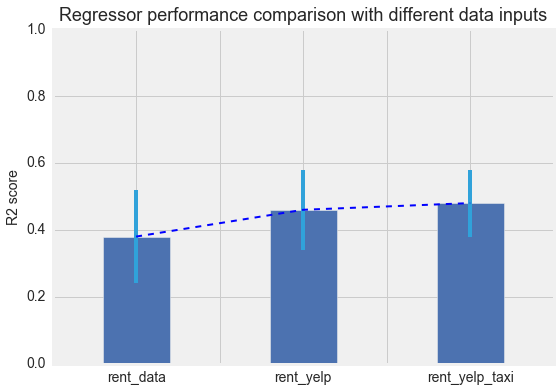

In [403]:
# Comparing regressor performances with different input data

x = [0,1,2]

y = [rent_reg_model.iloc[0, 2], rent_yelp_reg_model.iloc[0,2], rent_yelp_taxi_reg_model.iloc[0,2]]
err = [rent_reg_model.iloc[0, 3], rent_yelp_reg_model.iloc[0,3], rent_yelp_taxi_reg_model.iloc[0,3]]

fig, ax = plt.subplots(figsize = (8,6))

plt.bar(x, y, align = 'center', width=0.4, yerr = err)
plt.plot(x, y, 'xb--', linewidth = 2)

#ax.set_ylim(45, 55)
ax.set_xticklabels(['', 'rent_data', '', 'rent_yelp', '', 'rent_yelp_taxi', ''])
ax.set_title('Regressor performance comparison with different data inputs', y = 1.01, fontsize = 18)
ax.set_ylim(0,1)
ax.tick_params(axis = 'both', labelsize = 14)
ax.set_ylabel('R2 score', fontsize = 14)
plt.savefig('regressor_compare.png');

#### Comments:

Predictive ability improved with additional dataset under regression modeling, with addition of both Yelp and taxi data.

## Binning taxi dropoff data into 4 subsets

In [404]:
rand = 44

In [405]:
X = rent_yelp_taxi[['SF_avail', 'Cost_mean', 'Cost_std',
                    'Rate_mean', 'Rate_std', 'Review_mean', 
                    'Review_std', 'Sentiment_mean', 'Sentiment_std',
                    'dropoff_hr_0600_1200', 'dropoff_hr_1200_1800', 
                    'dropoff_hr_1800_2359', 'dropoff_hr_2359_0600']]

X_taxibin = pd.concat([X, zip_dum], axis = 1)
y = rent_yelp_taxi['Price_per_sf_per_year']

# Create a independent train, test split and scaling to compare results
X_taxibin = X_taxibin.astype(float)

In [406]:
rent_yelp_taxibin_reg_model = custom_cross_val(X_taxibin, y, 10, model_reg, scales, 13)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:52: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/

In [407]:
rent_yelp_taxibin_reg_model.head()

Model          Scaler    R2 Stdev
18                        SVR  StandardScaler  0.49  0.15
11  GradientBoostingRegressor    RobustScaler  0.48   0.2
16        KNeighborsRegressor    MinMaxScaler  0.48  0.12
10  GradientBoostingRegressor    MinMaxScaler  0.44  0.18
17        KNeighborsRegressor    RobustScaler  0.44  0.15

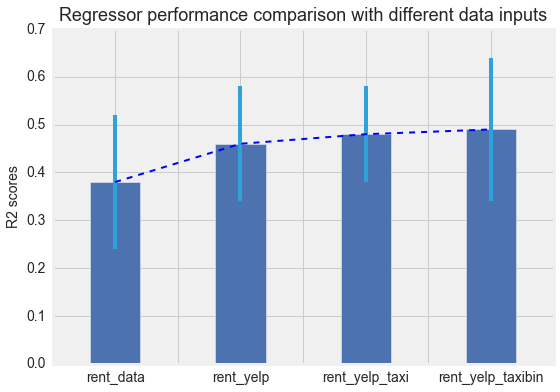

In [408]:
# Comparing regressor performances with different input data

x = [0,1,2, 3]

y = [rent_reg_model.iloc[0, 2], 
     rent_yelp_reg_model.iloc[0,2], 
     rent_yelp_taxi_reg_model.iloc[0,2], 
     rent_yelp_taxibin_reg_model.iloc[0,2]]

err = [rent_reg_model.iloc[0, 3], 
       rent_yelp_reg_model.iloc[0,3], 
       rent_yelp_taxi_reg_model.iloc[0,3], 
       rent_yelp_taxibin_reg_model.iloc[0,3]]

fig, ax = plt.subplots(figsize = (8,6))

plt.bar(x, y, align = 'center', width=0.4, yerr = err)
plt.plot(x, y, 'xb--', linewidth = 2)

#ax.set_ylim(45, 55)
ax.set_xticklabels(['', 'rent_data', 
                    '', 'rent_yelp', 
                    '', 'rent_yelp_taxi', 
                    '', 'rent_yelp_taxibin'])
ax.set_title('Regressor performance comparison with different data inputs', y = 1.01, fontsize = 18)
ax.tick_params(axis = 'both', labelsize = 14)
ax.set_ylabel('R2 scores', fontsize = 14)
plt.savefig('regressors_compare_bin.png');

## Feature selection for continuous features using Recursive Feature Selection (RFE)

In [409]:
X = rent_yelp_taxi[['SF_avail', 'Cost_mean', 'Cost_std',
                    'Rate_mean', 'Rate_std', 'Review_mean', 
                    'Review_std', 'Sentiment_mean', 'Sentiment_std',
                    'dropoff_hr_0600_1200', 'dropoff_hr_1200_1800', 
                    'dropoff_hr_1800_2359', 'dropoff_hr_2359_0600']]

y = rent_yelp_taxi['Price_per_sf_per_year']

# Create a independent train, test split and scaling to compare results
X = X.astype(float)

In [410]:
scale = StandardScaler()
model = GradientBoostingRegressor(random_state=rand, max_depth=2, learning_rate=0.095, n_estimators=59)

selector = RFECV(model, step = 1, cv=10, n_jobs=-1)
selector.fit(X,y)

#best_pred = custom_pred(X_taxibin, y, model, scale, 13)

RFECV(cv=10,
   estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.095, loss='ls', max_depth=2,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=59, presort='auto', random_state=44,
             subsample=1.0, verbose=0, warm_start=False),
   n_jobs=-1, scoring=None, step=1, verbose=0)

In [411]:
scale = StandardScaler()
model = GradientBoostingRegressor(random_state=rand, max_depth=2, learning_rate=0.095, n_estimators=59)

selector = RFE(model, n_features_to_select=1, step = 1)
selector.fit(X,y)

#best_pred = custom_pred(X_taxibin, y, model, scale, 13)

RFE(estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.095, loss='ls', max_depth=2,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=59, presort='auto', random_state=44,
             subsample=1.0, verbose=0, warm_start=False),
  n_features_to_select=1, step=1, verbose=0)

In [412]:
feature_importance = pd.DataFrame([X.columns, selector.ranking_])
feature_importance = feature_importance.T
feature_importance.columns = ['Feature', 'Rank']
feature_importance.sort_values('Rank', inplace = True)
feature_importance

Feature Rank
10  dropoff_hr_1200_1800    1
0               SF_avail    2
9   dropoff_hr_0600_1200    3
1              Cost_mean    4
11  dropoff_hr_1800_2359    5
5            Review_mean    6
12  dropoff_hr_2359_0600    7
6             Review_std    8
8          Sentiment_std    9
3              Rate_mean   10
7         Sentiment_mean   11
4               Rate_std   12
2               Cost_std   13

## Dropping low importance features

In [424]:
# Dropping "Cost_std", a measure of how varied the "$" ratings are for each of nearest 10 businesses on Yelp

X = rent_yelp_taxi[['SF_avail', 'Cost_mean', 
                    'Rate_mean','Rate_std', 'Review_mean', 
                    'Review_std', 'Sentiment_mean','Sentiment_std',
                    'dropoff_hr_0600_1200', 'dropoff_hr_1200_1800', 
                    'dropoff_hr_1800_2359', 'dropoff_hr_2359_0600']]

# Concatenating with zipcode dummy columns
X_taxibin = pd.concat([X, zip_dum], axis = 1)
y = rent_yelp_taxi['Price_per_sf_per_year']

# Converting to float
X_taxibin = X_taxibin.astype(float)

In [425]:
ryt_drop_feat_reg_model = custom_cross_val(X_taxibin, y, 10, model_reg, scales, 12)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:52: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/

In [426]:
ryt_drop_feat_reg_model.head()

Model          Scaler    R2 Stdev
0   RandomForestRegressor  StandardScaler  0.52  0.15
16    KNeighborsRegressor    MinMaxScaler  0.49   0.1
1   RandomForestRegressor    MinMaxScaler  0.46  0.14
20                    SVR    RobustScaler  0.46  0.14
2   RandomForestRegressor    RobustScaler  0.46  0.24

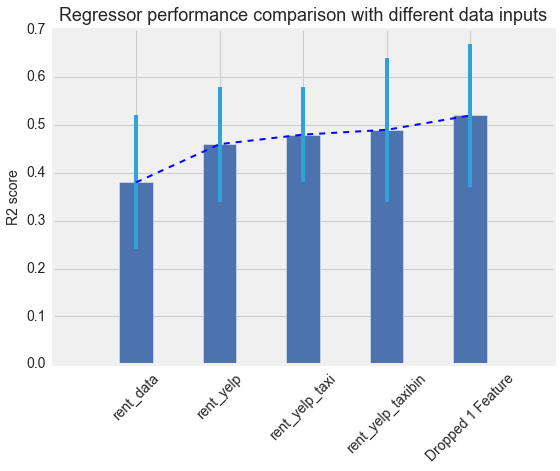

In [437]:
# Comparing regressor performances with different input data

x = [0,1,2, 3, 4]

y = [rent_reg_model.iloc[0, 2], 
     rent_yelp_reg_model.iloc[0,2], 
     rent_yelp_taxi_reg_model.iloc[0,2], 
     rent_yelp_taxibin_reg_model.iloc[0,2],
     ryt_drop_feat_reg_model.iloc[0,2]
    ]

err = [rent_reg_model.iloc[0, 3], 
       rent_yelp_reg_model.iloc[0,3], 
       rent_yelp_taxi_reg_model.iloc[0,3], 
       rent_yelp_taxibin_reg_model.iloc[0,3],
       ryt_drop_feat_reg_model.iloc[0,3]
      ]

fig, ax = plt.subplots(figsize = (8,6))

plt.bar(x, y, align = 'center', width=0.4, yerr = err)
plt.plot(x, y, 'xb--', linewidth = 2)

#ax.set_ylim(45, 55)
ax.set_xticklabels(['', 'rent_data', 
                    'rent_yelp', 
                    'rent_yelp_taxi', 
                    'rent_yelp_taxibin',
                    'Dropped 1 Feature'
                   ], rotation = 45)
ax.set_title('Regressor performance comparison with different data inputs', y = 1.01, fontsize = 18)
ax.tick_params(axis = 'both', labelsize = 14)
ax.set_ylabel('R2 score', fontsize = 14)
plt.savefig('regressors_compare_bin.png');

### Comments:

"Cost_std", the standard deviation of "\$" rating on Yelp across neighboring business, a measure of how varied the types of business are within a location, was the lowest ranking continuous features. Removing it improved the performance of the model, increased R2 score from 0.7 to 0.71.

Nevertheless, removing the feature also resulted in higher standard deviation of R2 scores with the higher standard deviation of 0.38 compared to 0.37. This means that while the model with 1 less feature could explain the variance of the data slightly better than the full feature set on average, it also got higher errors more often compared to using the full feature set.

Whe the second ranked model/scaler pair was examined, it returned similar R2 performance (0.7) as model with the full feature set but has a lower standard deviation of 0.33 compared to 0.37. Hence, this pair was chosen for gridsearch.

## GridSearch optimal algorithms for better performance

In [438]:
# Dropping "Cost_std"

X = rent_yelp_taxi[['SF_avail', 'Cost_mean', 
                    'Rate_mean','Rate_std', 'Review_mean', 
                    'Review_std', 'Sentiment_mean','Sentiment_std',
                    'dropoff_hr_0600_1200', 'dropoff_hr_1200_1800', 
                    'dropoff_hr_1800_2359', 'dropoff_hr_2359_0600']]

X_taxibin = pd.concat([X, zip_dum], axis = 1)
y = rent_yelp_taxi['Price_per_sf_per_year']

# Create a independent train, test split and scaling to compare results
X_taxibin = X_taxibin.astype(float)

In [444]:
models = [
    KNeighborsRegressor(n_neighbors=4, weights='uniform', leaf_size=20),
    KNeighborsRegressor(n_neighbors=4, weights='distance', leaf_size=20),
    KNeighborsRegressor(n_neighbors=4, weights='uniform', leaf_size=30),
    KNeighborsRegressor(n_neighbors=4, weights='distance', leaf_size=30),
    KNeighborsRegressor(n_neighbors=4, weights='uniform', leaf_size=40),
    KNeighborsRegressor(n_neighbors=4, weights='distance', leaf_size=40),
    KNeighborsRegressor(n_neighbors=5, weights='uniform', leaf_size=20),
    KNeighborsRegressor(n_neighbors=5, weights='distance', leaf_size=20),
    KNeighborsRegressor(n_neighbors=5, weights='uniform', leaf_size=30),
    KNeighborsRegressor(n_neighbors=5, weights='distance', leaf_size=30),
    KNeighborsRegressor(n_neighbors=5, weights='uniform', leaf_size=40),
    KNeighborsRegressor(n_neighbors=5, weights='distance', leaf_size=40),
    KNeighborsRegressor(n_neighbors=6, weights='uniform', leaf_size=20),
    KNeighborsRegressor(n_neighbors=6, weights='distance', leaf_size=20),
    KNeighborsRegressor(n_neighbors=6, weights='uniform', leaf_size=30),
    KNeighborsRegressor(n_neighbors=6, weights='distance', leaf_size=30),
    KNeighborsRegressor(n_neighbors=6, weights='uniform', leaf_size=40),
    KNeighborsRegressor(n_neighbors=6, weights='distance', leaf_size=40),
         ]

In [445]:
gs_reg_model = custom_cross_val(X_taxibin, y, 10, models, [MinMaxScaler()], 12)

In [446]:
gs_reg_model.head()

Model        Scaler    R2 Stdev
14  KNeighborsRegressor  MinMaxScaler  0.51  0.15
16  KNeighborsRegressor  MinMaxScaler  0.51  0.15
15  KNeighborsRegressor  MinMaxScaler   0.5  0.19
7   KNeighborsRegressor  MinMaxScaler   0.5  0.19
13  KNeighborsRegressor  MinMaxScaler  0.49  0.11

## Creating a baseline model

In [311]:
zip_dum = pd.get_dummies(rent_yelp_taxi['Zipcode'], prefix='Zip_', drop_first=True)
X = pd.concat([rent_yelp_taxi['SF_avail'], zip_dum], axis = 1)
y = rent_yelp_taxi['Price_per_sf_per_year']

In [312]:
scale = MinMaxScaler()
model = GradientBoostingRegressor(random_state=rand)

base_pred = custom_pred(X, y, model, scale, 1)

//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [313]:
from sklearn.metrics import r2_score

r2_score(y, base_pred)

0.77309195405433417

In [153]:
results = pd.DataFrame([y, base_pred])
results = results.T
results.columns = ['True_PSF', 'base']
results.head()

True_PSF        base
0    118.75   90.906355
1    140.00  110.300898
2     39.54   59.243767
3     35.00   51.419393
4    149.61  124.138996

## Best model parameters

In [314]:
X = rent_yelp_taxi[['SF_avail', 'Cost_mean',
                    'Rate_mean', 'Rate_std', 'Review_mean', 
                    'Review_std', 'Sentiment_mean', 'Sentiment_std',
                    'dropoff_hr_0600_1200', 'dropoff_hr_1200_1800', 
                    'dropoff_hr_1800_2359', 'dropoff_hr_2359_0600']]

X_taxibin = pd.concat([X, zip_dum], axis = 1)
y = rent_yelp_taxi['Price_per_sf_per_year']

# Create a independent train, test split and scaling to compare results
X_taxibin = X_taxibin.astype(float)

In [315]:
scale = MinMaxScaler()
model = RandomForestRegressor(max_depth=4, max_features=0.5)

best_pred = custom_pred(X_taxibin, y, model, scale, 12)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [316]:
r2_score(y, best_pred)

0.69751340420853403

In [292]:
results['Pred_PSF'] = best_pred

In [293]:
results.head()

True_PSF        base    Pred_PSF
0    118.75   90.906355  115.730122
1    140.00  110.300898  124.883494
2     39.54   59.243767   50.946859
3     35.00   51.419393  105.322009
4    149.61  124.138996  143.252319

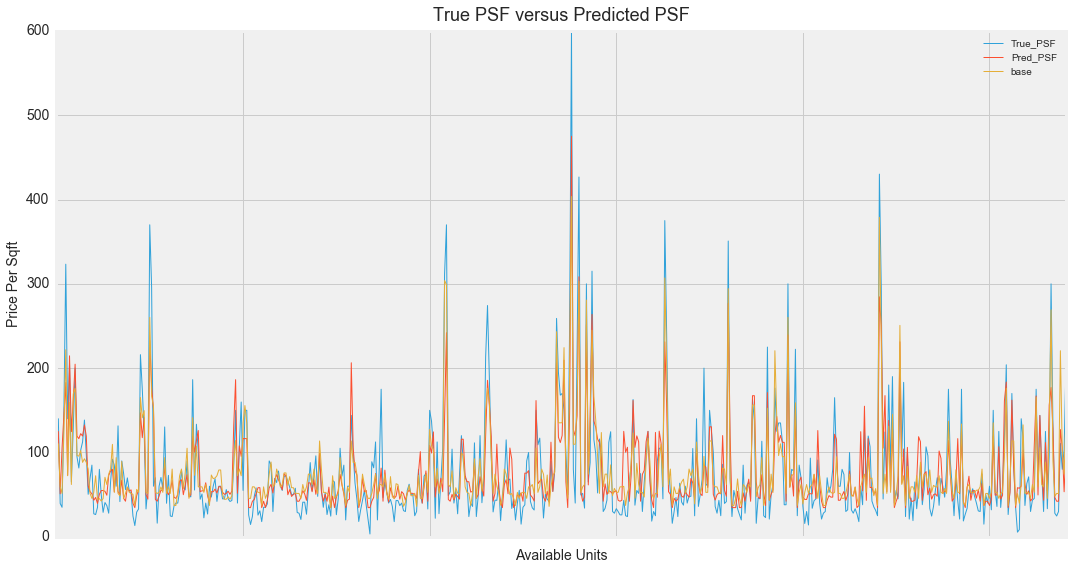

In [294]:
ax = results[['True_PSF', 'Pred_PSF', 'base']].plot(figsize = (15,8), linewidth = 1)
ax.tick_params(axis = 'both', labelsize = 14)
ax.set_title('True PSF versus Predicted PSF', y = 1.01, fontsize = 18)
ax.set_xticklabels('')
ax.set_xlabel('Available Units', fontsize = 14)
ax.set_ylabel("Price Per Sqft", fontsize = 14)
plt.tight_layout()

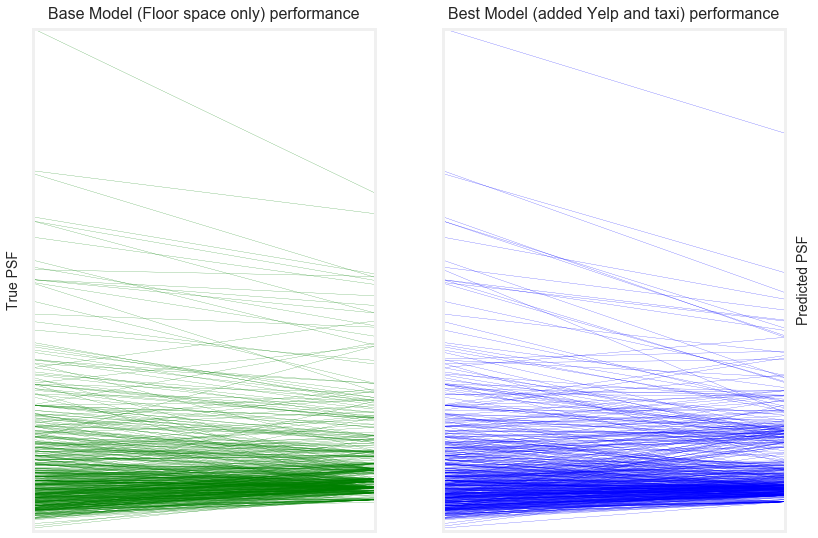

In [295]:
fig, axes = plt.subplots(1,2, figsize=(12,9))

axes_details = type(axes)
fig_details = type(fig)

# Specifying the x axis
x = [0,1]

# y values for both best model and base model
a = results[['True_PSF', 'base']].T.values
b = results[['True_PSF', 'Pred_PSF']].T.values

# Creating dual axes for both plots
ax0 = axes[0].twinx()
ax1 = axes[1].twinx()

# Setting background to white for both plots
axes[0].set_axis_bgcolor('white')
axes[1].set_axis_bgcolor('white')

# Plotting the model performances
axes[0].plot(x, a, 'xg-', linewidth = 0.2)
axes[1].plot(x, b, 'xb-', linewidth = 0.2)

# Turning off gridlines
axes[0].grid(None)
axes[1].grid(None)
ax0.grid(None)
ax1.grid(None)

# Removing x tick labels
axes[0].set_xticklabels([])
ax0.set_yticklabels([])
axes[0].set_yticklabels([])

axes[1].set_xticklabels([])
ax1.set_yticklabels([])
axes[1].set_yticklabels([])


axes[0].set_ylabel('True PSF', fontsize = 14)
axes[1].set_ylabel('')
ax0.set_ylabel('')
ax1.set_ylabel('Predicted PSF', fontsize = 14)


axes[0].set_title('Base Model (Floor space only) performance', y = 1.01, fontsize = 16)
axes[1].set_title('Best Model (added Yelp and taxi) performance', y = 1.01, fontsize = 16)

 
#plt.savefig('yelp_performance_compare.png');

### Comments:

The visualization above shows the performance of every available rental location in the dataset using a baseline model (Floor space and zipcodes) compared to the best model. Ideally, we would like to see lines with zero gradient, i.e. the model predicts exactly the value of the true price.

## Pickling best model

In [160]:
with open('/Users/peidacai/Desktop/best_model.pkl', 'w') as f:
    pickle.dump(grid.best_estimator_, f)

In [34]:
clf = make_pipeline(StandardScaler(),
                    SelectPercentile(percentile=61),
                    RandomForestRegressor(criterion='mse', n_estimators=9)
                   )

In [57]:
X = rent_yelp_taxi[['SF_avail', 'Cost_mean', 'Cost_std',
                    'Rate_mean', 'Rate_std', 'Review_mean', 
                    'Review_std', 'Sentiment_mean', 'Sentiment_std',
                    'dropoff_hr_0600_1200', 'dropoff_hr_1200_1800', 
                    'dropoff_hr_1800_2359', 'dropoff_hr_2359_0600']]

In [58]:
ss = StandardScaler()

In [59]:
ss.fit(X)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [60]:
X_scale = pd.DataFrame(ss.transform(X), 
                       columns = [
        'SF_avail', 'Cost_mean', 'Cost_std',
        'Rate_mean', 'Rate_std', 'Review_mean', 
        'Review_std', 'Sentiment_mean', 'Sentiment_std',
        'dropoff_hr_0600_1200', 'dropoff_hr_1200_1800', 
        'dropoff_hr_1800_2359', 'dropoff_hr_2359_0600'
    ])

In [65]:
X_scale.shape

(542, 13)

In [62]:
X_taxibin = pd.concat([X_scale, zip_dum], axis = 1)
X_taxibin.head()

SF_avail  Cost_mean  Cost_std  Rate_mean  Rate_std  Review_mean  \
0  0.389820   2.745242  2.083902   0.856615 -0.779636     0.756493   
1  0.517359   0.776658  0.377282  -0.415399 -0.657157     0.378787   
2 -0.379307  -0.535731  0.562745  -0.415399  0.155690    -0.597751   
3  0.269367   0.448561 -0.187100  -0.924205  0.155690    -0.056890   
4 -0.558569  -0.207634  0.424486   1.365420 -0.991115     0.727806   

   Review_std  Sentiment_mean  Sentiment_std  dropoff_hr_0600_1200  \
0    0.543757       -0.676829      -0.262126              0.348839   
1    0.013737       -1.079577      -0.150316             -0.012032   
2   -0.669196        0.343823      -0.517247             -0.274174   
3   -0.211070       -0.526227      -0.606605              0.384586   
4    0.819556        0.224528      -0.796437             -0.005223   

      ...      Zip__11421  Zip__11426  Zip__11427  Zip__11429  Zip__11432  \
0     ...               0           0           0           0           0   
1     ...               0           0           0           0           0   
2     ...               0           0           0           0           0   
3     ...               0           0           0           0           0   
4     ...               0           0           0           0           0   

   Zip__11433  Zip__11434  Zip__11435  Zip__11436  Zip__11694  
0           0           0           0           0           0  
1           0           0           0           0           0  
2           0           0           0           0           0  
3           0           0           0           0           0  
4           0           0           0           0           0  

[5 rows x 137 columns]

In [ ]:
X_taxibin

In [64]:
clf.fit(X_taxibin,y)

Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('selectpercentile', SelectPercentile(percentile=61,
         score_func=<function f_classif at 0x119977938>)), ('randomforestregressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
      ...stimators=9, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))])

In [40]:
for i in X_taxibin.columns:
    if X_taxibin[i].sum() == 0:
        print i
    

In [42]:
x_scale = pd.DataFrame(StandardScaler().fit_transform(X_taxibin), columns = X_taxibin.columns)
x_scale.head()

SF_avail  Cost_mean  Cost_std  Rate_mean  Rate_std  Review_mean  \
0  0.389820   2.745242  2.083902   0.856615 -0.779636     0.756493   
1  0.517359   0.776658  0.377282  -0.415399 -0.657157     0.378787   
2 -0.379307  -0.535731  0.562745  -0.415399  0.155690    -0.597751   
3  0.269367   0.448561 -0.187100  -0.924205  0.155690    -0.056890   
4 -0.558569  -0.207634  0.424486   1.365420 -0.991115     0.727806   

   Review_std  Sentiment_mean  Sentiment_std  Zip__10002  \
0    0.543757       -0.676829      -0.262126   -0.200766   
1    0.013737       -1.079577      -0.150316   -0.200766   
2   -0.669196        0.343823      -0.517247   -0.200766   
3   -0.211070       -0.526227      -0.606605   -0.200766   
4    0.819556        0.224528      -0.796437   -0.200766   

           ...           Zip__11432  Zip__11433  Zip__11434  Zip__11435  \
0          ...            -0.042993   -0.042993   -0.042993   -0.060858   
1          ...            -0.042993   -0.042993   -0.042993   -0.060858   
2          ...            -0.042993   -0.042993   -0.042993   -0.060858   
3          ...            -0.042993   -0.042993   -0.042993   -0.060858   
4          ...            -0.042993   -0.042993   -0.042993   -0.060858   

   Zip__11436  Zip__11694  dropoff_hr_0600_1200  dropoff_hr_1200_1800  \
0   -0.042993   -0.042993              0.348839              0.649422   
1   -0.042993   -0.042993             -0.012032              0.140752   
2   -0.042993   -0.042993             -0.274174             -0.333400   
3   -0.042993   -0.042993              0.384586              0.126219   
4   -0.042993   -0.042993             -0.005223              0.227953   

   dropoff_hr_1800_2359  dropoff_hr_2359_0600  
0              0.650292              0.710333  
1              0.048216              0.141958  
2             -0.390551             -0.247602  
3              0.345319              1.521385  
4              0.321708              0.065323  

[5 rows x 137 columns]

In [44]:
for i in x_scale.columns:
    if (x_scale[i] - x_scale[i].mean()).sum() < 1:
        print i

SF_avail
Cost_mean
Cost_std
Rate_mean
Rate_std
Review_mean
Review_std
Sentiment_mean
Sentiment_std
Zip__10002
Zip__10003
Zip__10004
Zip__10005
Zip__10007
Zip__10009
Zip__10010
Zip__10011
Zip__10012
Zip__10013
Zip__10014
Zip__10016
Zip__10017
Zip__10018
Zip__10019
Zip__10021
Zip__10022
Zip__10023
Zip__10024
Zip__10025
Zip__10026
Zip__10027
Zip__10028
Zip__10029
Zip__10030
Zip__10031
Zip__10032
Zip__10033
Zip__10035
Zip__10036
Zip__10038
Zip__10039
Zip__10040
Zip__10065
Zip__10075
Zip__10128
Zip__10301
Zip__10302
Zip__10304
Zip__10306
Zip__10307
Zip__10309
Zip__10312
Zip__10314
Zip__10451
Zip__10452
Zip__10453
Zip__10454
Zip__10455
Zip__10456
Zip__10458
Zip__10459
Zip__10460
Zip__10461
Zip__10462
Zip__10466
Zip__10467
Zip__10468
Zip__10469
Zip__10471
Zip__10472
Zip__10475
Zip__11001
Zip__11101
Zip__11102
Zip__11103
Zip__11105
Zip__11106
Zip__11201
Zip__11203
Zip__11204
Zip__11205
Zip__11206
Zip__11207
Zip__11208
Zip__11209
Zip__11210
Zip__11211
Zip__11212
Zip__11213
Zip__11214
Zip__11215